In [ ]:
import torch
import torchvision
from torchvision.datasets import FashionMNIST # torchvision for image datasets
from torchtext.datasets import AmazonReviewFull # torchtext for text
from torchaudio.datasets import SPEECHCOMMANDS #torchaudio for audio

training_data = FashionMNIST(
    # the directory you want to store the dataset, can be a string e.g. "data"
    root = '', 
    # if set to False, will give you the test set instead
    train = True, 
    # download the dataset if it's not already available in the root path you specified
    download = True, 
    # as the name implies, will transform images to tensor data structures so PyTorch can use them for training
    transform = torchvision.transforms.ToTensor() 
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/raw



In [ ]:
training_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
training_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size = 32, shuffle = True)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
# 'cuda'

data = [[1, 2], [3, 4]]
tensor = torch.tensor(data)

# you can specify .to("cuda") or .to(device)
tensor = tensor.to("cuda")

Device: cuda


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ccc1ef61-2360-4e7b-b9d3-fb50212a91d7)


# Örnek Proje

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize, Compose
import os
import matplotlib.pyplot as plt
import numpy as np

First, since we should normalize our images before feeding them to the model, we will define a transform function, and use torchvision.transforms.Normalize to normalize all of our images when we create the training and test data variables. The Normalize method takes the desired mean and standard deviation as agruments, and since these are color images, a value should be provided for each (R, G, B) color channel.

In [ ]:
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5),  # mean
               (0.5, 0.5, 0.5))] # std. deviation
)

In [ ]:
training_data = CIFAR10(root="cifar",
                        train = True, # train set, 50k images
                        download = True,
                        transform=transform)
test_data = CIFAR10(root = "cifar",
                    train = False, # test set, 10k images
                    download = True,
                    transform = transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar/cifar-10-python.tar.gz to cifar
Files already downloaded and verified


In [ ]:
batch_size = 4
train_dataloader = DataLoader(training_data, 
                              batch_size=batch_size, 
                              shuffle=True)
test_dataloader = DataLoader(test_data, 
                             batch_size=batch_size, 
                             shuffle=True)

In [ ]:
for X, y in train_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([4, 3, 32, 32])
Shape of y: torch.Size([4]) torch.int64


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


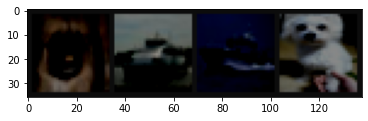

dog   ship  ship  dog  


In [ ]:
def imshow(img):
  img = img / 2 + .05 # revert normalization for viewing
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

classes = training_data.classes
print(training_data.classes)

dataiter = iter(train_dataloader)
images, labels = dataiter.next()
imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        
model = NeuralNetwork().to(device)

print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( model.parameters(), lr=0.001 ) # momentum=0.9

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 2000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303754  [    0/50000]
loss: 1.926201  [ 8000/50000]
loss: 1.925548  [16000/50000]
loss: 1.889365  [24000/50000]
loss: 1.399667  [32000/50000]
loss: 1.670289  [40000/50000]
loss: 1.553211  [48000/50000]
Test Error: 
 Accuracy: 39.9%, Avg loss: 1.712941 

Epoch 2
-------------------------------
loss: 1.492062  [    0/50000]
loss: 1.718390  [ 8000/50000]
loss: 1.148451  [16000/50000]
loss: 1.823087  [24000/50000]
loss: 1.500117  [32000/50000]
loss: 1.297272  [40000/50000]
loss: 1.012112  [48000/50000]
Test Error: 
 Accuracy: 45.4%, Avg loss: 1.569835 

Epoch 3
-------------------------------
loss: 1.324352  [    0/50000]
loss: 1.098440  [ 8000/50000]
loss: 1.192223  [16000/50000]
loss: 1.601385  [24000/50000]
loss: 1.384969  [32000/50000]
loss: 1.907831  [40000/50000]
loss: 2.273684  [48000/50000]
Test Error: 
 Accuracy: 47.4%, Avg loss: 1.489881 

Epoch 4
-------------------------------
loss: 0.534164  [    0/50000]
loss: 2.041487  [ 8000/5

In [ ]:
torch.save(model.state_dict(), "cifar_fc.pth")

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("cifar_fc.pth"))

<All keys matched successfully>

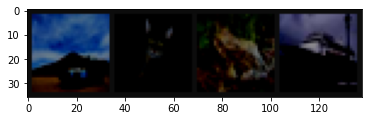

Ground Truth:  truck cat   frog  ship 


In [ ]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

imshow(make_grid(images))
print('Ground Truth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  airplane frog  frog  airplane


In [ ]:
correct = 0
total = 0

with torch.no_grad():
   for data in test_dataloader:
     images, labels = data
     outputs = model(images)
     _, predicted = torch.max(outputs.data, 1)
     total += labels.size(0)
     correct += (predicted == labels).sum().item()
     
print(f'Model accuracy: {100 * correct // total} %')

Model accuracy: 53 %


In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0  for classname in classes}

with torch.no_grad():
  for data in test_dataloader:
    images, labels = data
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    for label,prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f'Accuracy for class {classname:5s}: {accuracy:.1f}%')

Accuracy for class airplane: 68.8%
Accuracy for class automobile: 63.5%
Accuracy for class bird : 37.0%
Accuracy for class cat  : 36.8%
Accuracy for class deer : 45.2%
Accuracy for class dog  : 49.2%
Accuracy for class frog : 65.0%
Accuracy for class horse: 57.4%
Accuracy for class ship : 60.1%
Accuracy for class truck: 55.7%
